In [31]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from ast import literal_eval
import numpy as np

In [68]:
# attack_type = 'none'
datasets = 'pokec_n bail dblp'.split()
# stats = 'homophily community'.split()
df_results = pd.DataFrame()
for dataset in datasets:
    for attack_type in 'none y1s1-DD'.split():
        c_attack_type = attack_type
        fname = f'../../results/stats-latent-{dataset}-{c_attack_type}.csv'
        if not os.path.exists(fname):
            print(f'File not found: {fname}')
            continue
        df_current = pd.read_csv(fname)
        df_current['dataset'] = dataset
        df_current['attack_type'] = attack_type
        df_results = pd.concat([df_results, df_current], ignore_index=True)

File not found: ../../results/stats-latent-pokec_n-none.csv
File not found: ../../results/stats-latent-pokec_n-y1s1-DD.csv
File not found: ../../results/stats-latent-bail-none.csv
File not found: ../../results/stats-latent-bail-y1s1-DD.csv


In [69]:
df_results.hidden_representations = df_results.hidden_representations.apply(lambda x:np.array(literal_eval(x)))

In [70]:
df_results.label = df_results.label.apply(lambda x:np.array(literal_eval(x)))

In [71]:
df_results.sens = df_results.sens.apply(lambda x:np.array(literal_eval(x)))

In [72]:
df_results.hidden_representations[0].shape

(20111, 16)

In [73]:
df_results.columns

Index(['attack', 'hidden_representations', 'label', 'ptb_rate', 'seed', 'sens',
       'dataset', 'attack_type'],
      dtype='object')

In [74]:
import umap

In [75]:
reducer = umap.UMAP()

In [91]:
def scatter_hidden(x,y,s, *args, **kwargs):
    x = x.values[0]
    y = y.values[0]
    s = s.values[0]
    idx = (y!=-1) & (s!=-1)
    x = x[idx]
    s = s[idx]
    y = y[idx]
    ys = [f'y{yy}s{int(ss)}' for yy,ss in zip(y,s)]
    x = reducer.fit_transform(x)
    sns.scatterplot(x[:,0],x[:,1],hue=ys,style=ys,alpha=.1,s=150, **kwargs)
#     plt.legend()


/home/hhussain/anaconda3/envs/fair/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


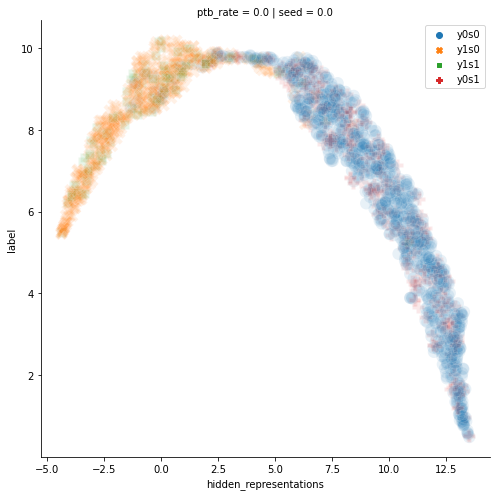

In [92]:
g = sns.FacetGrid(data=df_results[df_results.ptb_rate==0],
                  col='seed',row='ptb_rate', sharex=True, sharey=True, height=7)
g.map(scatter_hidden, 'hidden_representations','label','sens')
plt.legend()
plt.show()


/home/hhussain/anaconda3/envs/fair/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/hhussain/anaconda3/envs/fair/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/hhussain/anaconda3/envs/fair/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

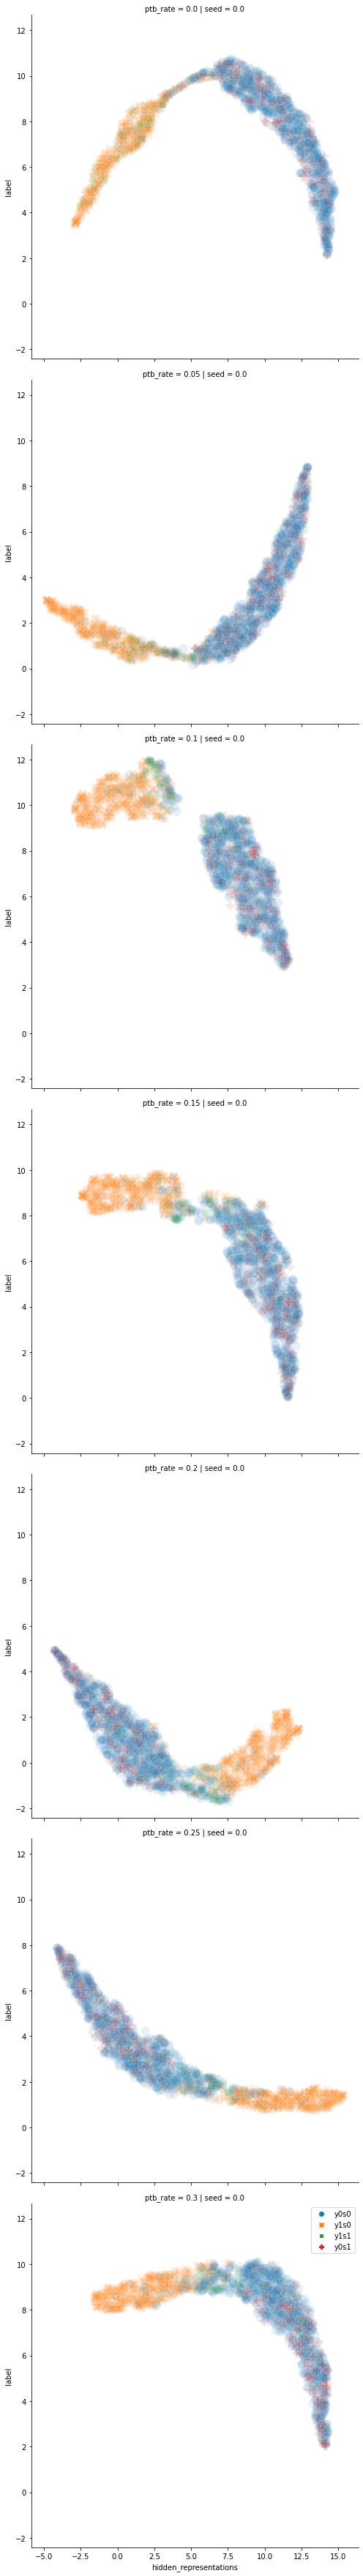

In [94]:
g = sns.FacetGrid(data=df_results[df_results.seed==0],
                  col='seed',row='ptb_rate', sharex=True, sharey=True, height=7)
g.map(scatter_hidden, 'hidden_representations','label','sens')
plt.legend()
plt.show()


/home/hhussain/anaconda3/envs/fair/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/hhussain/anaconda3/envs/fair/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/hhussain/anaconda3/envs/fair/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

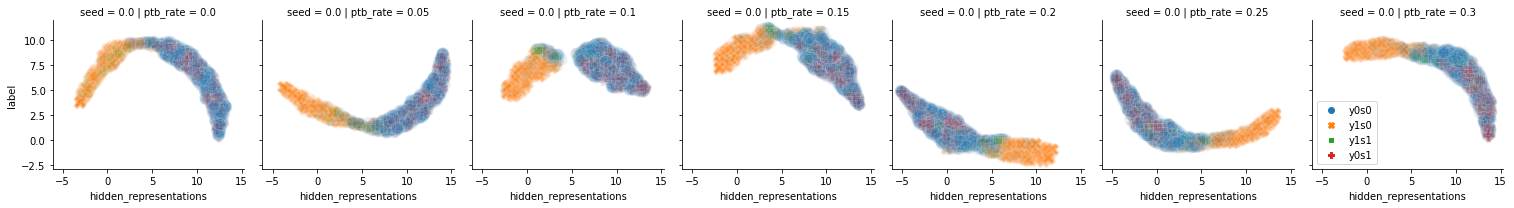

In [95]:
g = sns.FacetGrid(data=df_results[df_results.seed==0],
                  row='seed',col='ptb_rate', sharex=True, sharey=True, height=3)
g.map(scatter_hidden, 'hidden_representations','label','sens')
plt.legend()
plt.show()


In [117]:
def distance(x,y):
    x = x.copy()
    y = y.copy()
    L = min(len(x),len(y))
    np.random.shuffle(x)
    np.random.shuffle(y)
    x=x[:L]
    y=y[:L]
    diff = (x-y)**2
    return np.sum(np.sum(diff,axis=1))

def distance_hidden(x,y,label,sens, *args, **kwargs):
    df = pd.DataFrame({'ptb_rate':x, 'y':y})
    label = label.values[0]
    sens = sens.values[0]
    y0s0 = (label==0) & (sens==0)
    y0s1 = (label==0) & (sens==1)
    y1s0 = (label==1) & (sens==0)
    y1s1 = (label==1) & (sens==1)
    df['y0s0'] = df.y.apply(lambda v:distance(v[y1s1],v[y0s0]))
    df['y1s0'] = df.y.apply(lambda v:distance(v[y1s1],v[y1s0]))
    df['y1s1'] = df.y.apply(lambda v:distance(v[y1s1],v[y1s1]))
    df['y0s1'] = df.y.apply(lambda v:distance(v[y1s1],v[y0s1]))
    
    dfm = df.drop(columns=['y']).melt('ptb_rate', var_name='connection_type', value_name='distance')
#     print(dfm)
    
    sns.lineplot(data = dfm, x='ptb_rate', y='distance', hue='connection_type', style='connection_type', markers=True)


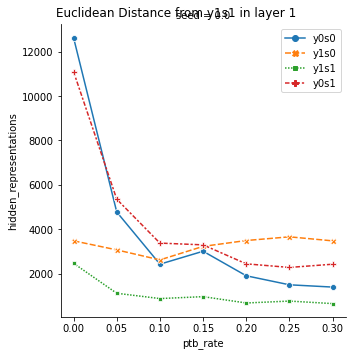

In [118]:
g = sns.FacetGrid(data=df_results[(df_results.seed==0)], row='seed', sharex=True, sharey=True,height=5)
g.map(distance_hidden,'ptb_rate', 'hidden_representations','label','sens',s=100)
plt.legend()
plt.suptitle('Euclidean Distance from y1s1 in layer 1')
plt.show()